# MARKET MIX MODELLING

## Importing Python Libraries

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# visualization
from matplotlib.pyplot import xticks
%matplotlib inline

pd.set_option('display.max_columns',None)

## Import Data set

In [2]:
ecom_data=pd.read_csv("ConsumerElectronics.csv")
ecom_data.head()

/Users/venramam/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400,1,\N,\N,COD,5,-1.01299130778588E+018,-7.79175582905735E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900,1,\N,\N,COD,7,-8.99032457905512E+018,7.33541149097431E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990,1,\N,\N,COD,10,-1.0404429420466E+018,-7.47768776228657E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690,1,\N,\N,Prepaid,4,-7.60496084352714E+018,-5.83593163877661E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618,1,\N,\N,Prepaid,6,2.8945572083453E+018,5.34735360997242E+017,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3


In [3]:
# make a copy of imported data frame
ecom_data_copy=ecom_data.copy()

## Inspecting the data frame

In [4]:
ecom_data_copy.shape

(1648824, 20)

In [5]:
ecom_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 20 columns):
fsn_id                             1648824 non-null object
order_date                         1648824 non-null object
Year                               1648824 non-null int64
Month                              1648824 non-null int64
order_id                           1648824 non-null float64
order_item_id                      1648824 non-null float64
gmv                                1648824 non-null object
units                              1648824 non-null int64
deliverybdays                      1648824 non-null object
deliverycdays                      1648824 non-null object
s1_fact.order_payment_type         1648824 non-null object
sla                                1648824 non-null int64
cust_id                            1648824 non-null object
pincode                            1648824 non-null object
product_analytic_super_category    1648824 non-null object
prod

## Data Cleaning

### Dropping irrelevent columns 

In [6]:
# Dropping irrelevent columns
col_irrelevent=['fsn_id','order_id','order_item_id','cust_id','pincode','product_analytic_super_category', 'product_analytic_category','product_analytic_vertical']
ecom_data_copy=ecom_data_copy.drop(col_irrelevent, axis=1)

In [7]:
ecom_data_copy.columns

Index(['order_date', 'Year', 'Month', 'gmv', 'units', 'deliverybdays',
       'deliverycdays', 's1_fact.order_payment_type', 'sla',
       'product_analytic_sub_category', 'product_mrp',
       'product_procurement_sla'],
      dtype='object')

### Changing data type

In [8]:
# converting gmv from object to numeric and any non numeric value to NAN
ecom_data_copy['gmv']=pd.to_numeric(ecom_data_copy['gmv'], errors='coerce')

### Missing value treatment

In [9]:
# deliverybdays and deliverycdays columns have many values as \N .
# It is actually NAN value lets replace it with NAN
ecom_data_copy[['deliverybdays','deliverycdays']]=ecom_data_copy[['deliverybdays','deliverycdays']].replace('\\N', np.nan)

In [10]:
# finding % of missing values in all columns
(ecom_data_copy.isna().mean().round(4) * 100).sort_values(ascending=False)

deliverycdays                    79.63
deliverybdays                    79.63
gmv                               0.30
product_procurement_sla           0.00
product_mrp                       0.00
product_analytic_sub_category     0.00
sla                               0.00
s1_fact.order_payment_type        0.00
units                             0.00
Month                             0.00
Year                              0.00
order_date                        0.00
dtype: float64

In [11]:
# 80% values are null in deliverycdays, deliverybdays coloumns lets drop them
ecom_data_copy=ecom_data_copy.drop(['deliverycdays','deliverybdays'], axis=1)

In [12]:
# filtering the rows having NAN in gmv columns
ecom_data_copy = ecom_data_copy[ecom_data_copy['gmv'].notna()]

In [13]:
ecom_data_copy.shape

(1643920, 10)

### Identifying and treating outliers

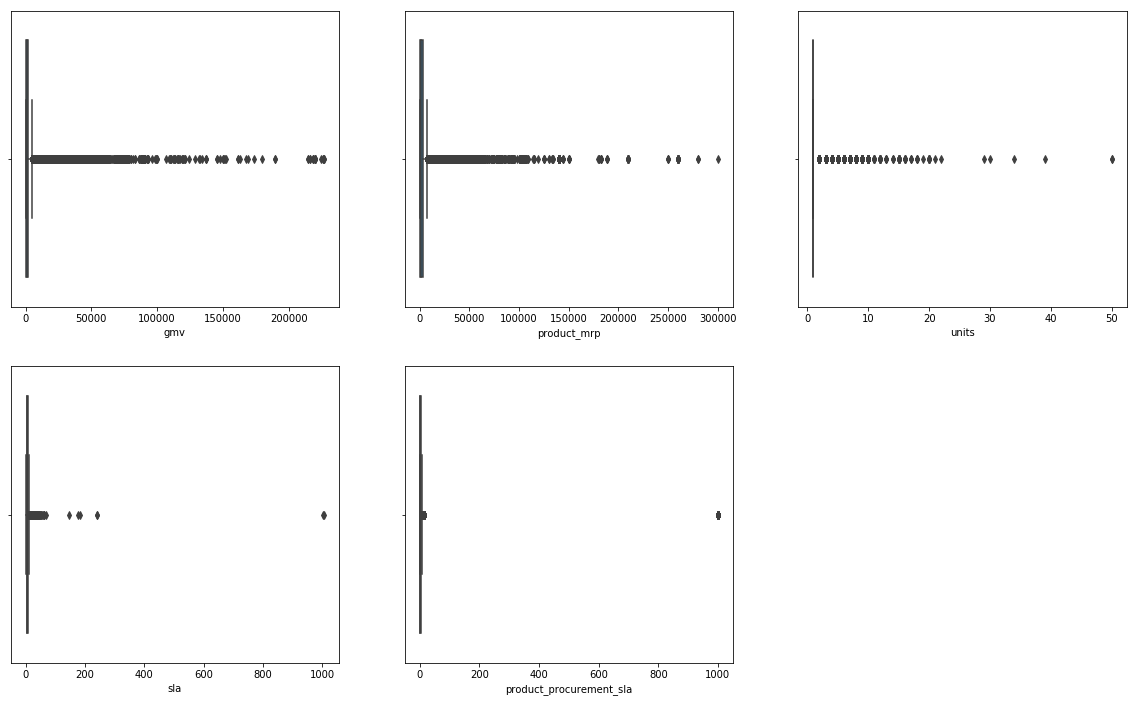

In [14]:
# Detecting and treating outliers
# for this we are taking here 5 numeric columns gmv, product_mrp,units, sla, product_procurement_sla
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x=ecom_data_copy['gmv'])
plt.subplot(2,3,2)
sns.boxplot(x=ecom_data_copy['product_mrp'])
plt.subplot(2,3,3)
sns.boxplot(x=ecom_data_copy['units'])
plt.subplot(2,3,4)
sns.boxplot(x=ecom_data_copy['sla'])
plt.subplot(2,3,5)
sns.boxplot(x=ecom_data_copy['product_procurement_sla'])



In [15]:
# columns sla, product_procurement_sla have outliers present 
Q1 = ecom_data_copy[['sla', 'product_procurement_sla']].quantile(0.25)
Q3 = ecom_data_copy[['sla', 'product_procurement_sla']].quantile(0.75)

IQR=Q3-Q1

# shape of application_data before removing outliers
ecom_data_copy.shape

(1643920, 10)

In [16]:
# removing outliers from above mentioned 2 columns
ecom_data_copy= ecom_data_copy[~((ecom_data_copy[['sla', 'product_procurement_sla']] < (Q1 - 1.5 * IQR)) |(ecom_data_copy[['sla', 'product_procurement_sla']] > (Q3 + 1.5 * IQR))).any(axis=1)]
ecom_data_copy.shape

(1571157, 10)

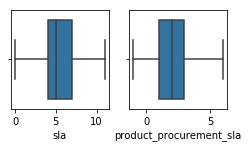

In [17]:
# checking both the variables again after removing outliers:
plt.subplot(2,3,1)
sns.boxplot(x=ecom_data_copy['sla'])
plt.subplot(2,3,2)
sns.boxplot(x=ecom_data_copy['product_procurement_sla'])

### UNIVARIATE ANALYSIS

#### Categorical features


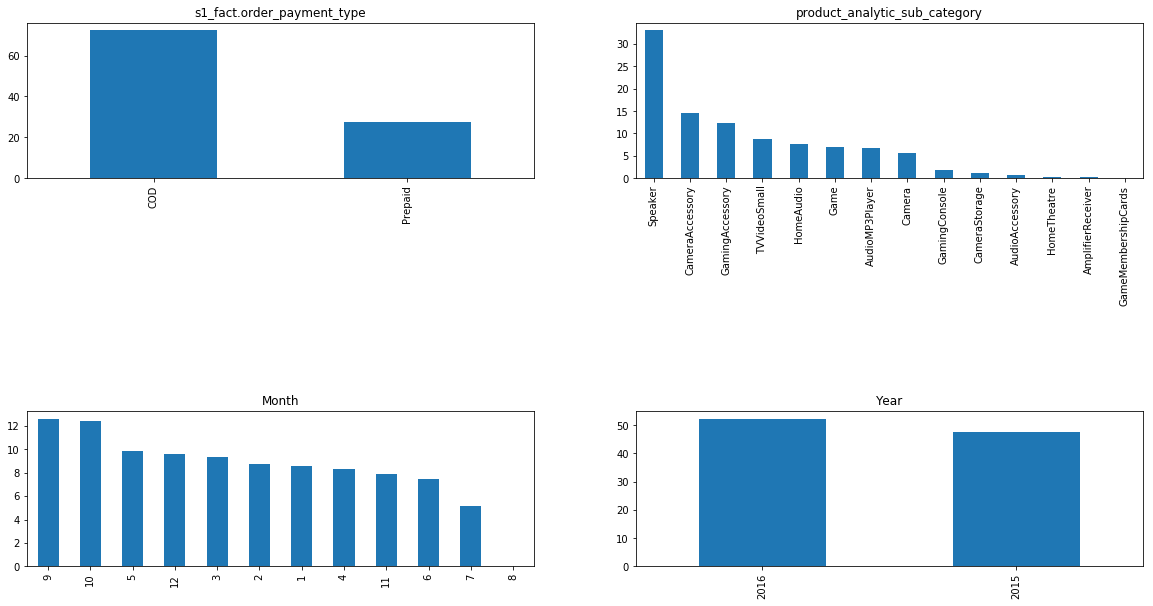

In [18]:
# s1_fact.order_payment_type,product_analytic_sub_category
categorical_features = ['s1_fact.order_payment_type','product_analytic_sub_category','Month','Year']
plt.rcParams["figure.figsize"] = [20,10]
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5)
for i, categorical_feature in enumerate(ecom_data_copy[categorical_features]):
    plt.subplot(2,2,i+1)
    (100*ecom_data_copy[categorical_feature].value_counts()/len(ecom_data_copy.index)).plot(kind='bar').set_title(categorical_feature)

#### Observations:
#### 1) 75% orders are cash on delivery and only 25% are prepaid
#### 2) Camera accessory,gaming accesory and home audio contribute almost 33% in total orders 
#### 3) highest number of orders are in September and October months then sale is decreasing constantly
#### 4) In terms of orders company is progressing as orders in 2016 are higher than 2015

#### Numerical variable

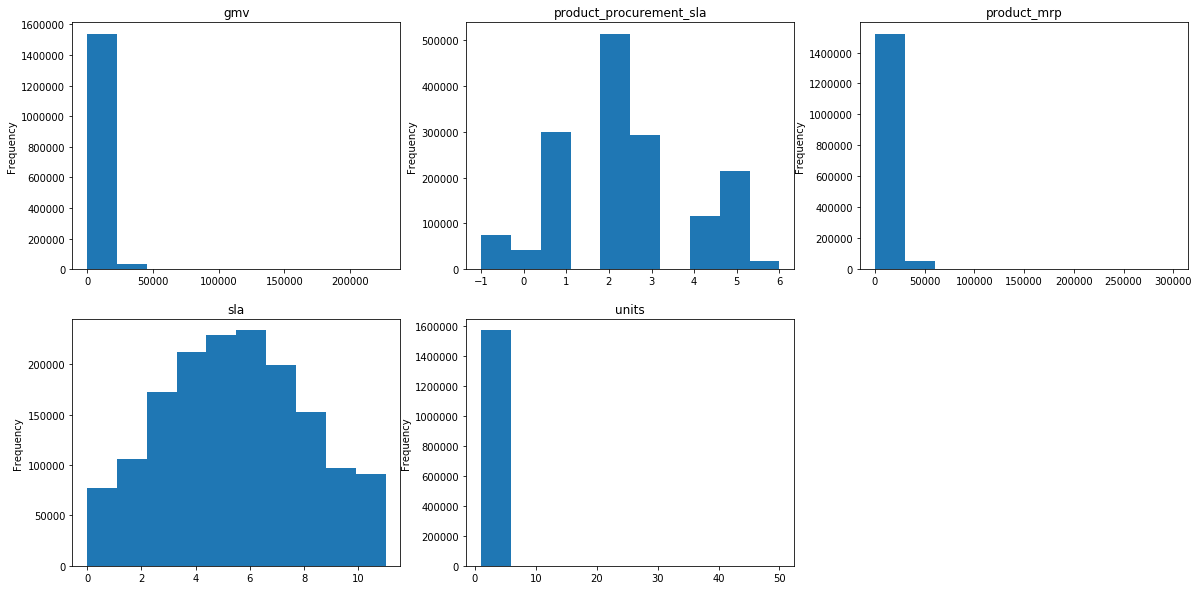

In [19]:
# gmv, product_procurement_sla, product_mrp,sla,units     
numerical_features = ['gmv', 'product_procurement_sla', 'product_mrp','sla','units']

plt.rcParams["figure.figsize"] = [20,10]
for i, numerical_feature in enumerate(ecom_data_copy[numerical_features]):
    plt.subplot(2,3,i+1)
    ecom_data_copy[numerical_feature].plot.hist().set_title(numerical_feature)

In [20]:
# few rows have negative values in product_procurement_sla which is invalid lets drop such rows
ecom_data_copy=ecom_data_copy.loc[ecom_data_copy.product_procurement_sla>=0]
ecom_data_copy.shape

(1496262, 10)

### Bivariate analysis

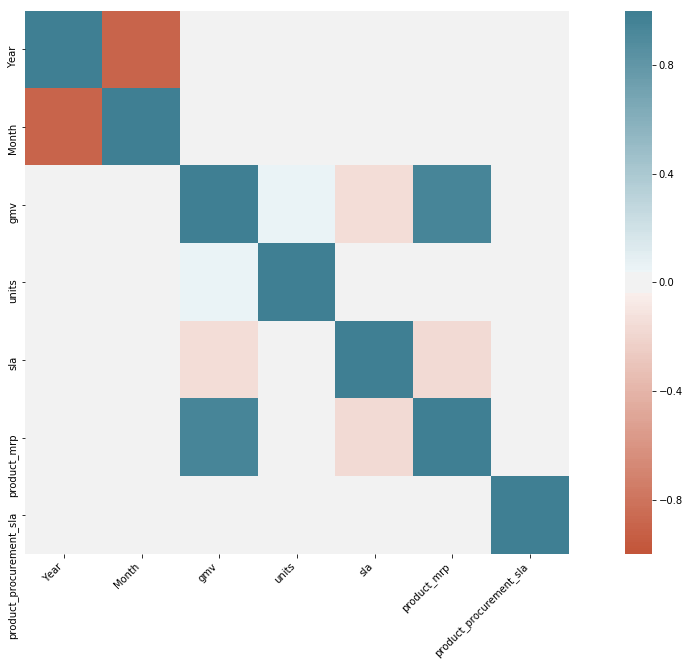

In [21]:
corr=ecom_data_copy.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

gmv is highly correlated with product_mrp so product_mrp is most important KPI
other important KPIs are holiday_flag and sla as they are also loosly related with gmv

## Data Preparation

In [22]:
# Converting order_date to datetime format
ecom_data_copy['order_date'] = pd.to_datetime(ecom_data_copy['order_date'])

# extracting week from order_date
ecom_data_copy['order_week']=ecom_data_copy['order_date'].dt.week

In [23]:
ecom_data_copy.head()

,order_date,Year,Month,gmv,units,s1_fact.order_payment_type,sla,product_analytic_sub_category,product_mrp,product_procurement_sla,order_week
0,2015-10-17 15:11:54,2015,10,6400.0,1,COD,5,CameraAccessory,7190,0,42
1,2015-10-19 10:07:22,2015,10,6900.0,1,COD,7,CameraAccessory,7190,0,43
2,2015-10-20 15:45:56,2015,10,1990.0,1,COD,10,CameraAccessory,2099,3,43
3,2015-10-14 12:05:15,2015,10,1690.0,1,Prepaid,4,CameraAccessory,2099,3,42
4,2015-10-17 21:25:03,2015,10,1618.0,1,Prepaid,6,CameraAccessory,2099,3,42


In [24]:
# Deriving new coloumn for holiday flag and pay day flag
# from the special sale day data we got holidays list as below
holidays=["2015-07-18","2015-07-19","2015-08-15","2015-08-16","2015-08-17","2015-08-28","2015-08-29","2015-08-30","2015-10-15",
          "2015-10-16","2015-10-17","2015-11-07","2015-11-08","2015-11-09","2015-11-10","2015-11-11","2015-11-12","2015-11-13",
          "2015-11-14","2015-12-25","2015-12-26","2015-12-27","2015-12-28","2015-12-29","2015-12-30","2016-01-01","2016-01-02",
          "2016-01-03","2016-01-20","2016-01-21","2016-01-22","2016-02-01","2016-02-02","2016-02-20","2016-02-21","2016-02-14",
          "2016-02-15","2016-03-07","2016-03-08","2016-03-09","2016-05-25","2016-05-26","2016-05-27"]
from datetime import datetime
holidays_list = [datetime.strptime(date, '%Y-%m-%d').date() for date in holidays]

ecom_data_copy['holiday_flag'] = [1 if x in holidays_list else 0 for x in ecom_data_copy['order_date'].dt.date] 

ecom_data_copy['payday_flag']=[1 if d in [1,15] else 0 for d in ecom_data_copy['order_date'].dt.day]

In [25]:
# drop coloumn order_date
ecom_data_copy=ecom_data_copy.drop(['order_date'], axis=1)


### Creating 3 separate file for selected sub categories

In [26]:
# creating 3 data frames for 3 different sub categories - camera accessory, home audio and gaming accessory
CameraAccessory_df=ecom_data_copy.loc[ecom_data_copy['product_analytic_sub_category']=='CameraAccessory']
HomeAudio_df=ecom_data_copy.loc[ecom_data_copy['product_analytic_sub_category']=='HomeAudio']
GamingAccessory_df=ecom_data_copy.loc[ecom_data_copy['product_analytic_sub_category']=='GamingAccessory']

In [27]:
# now drop product_analytic_sub_category from all three data frames
CameraAccessory_df=CameraAccessory_df.drop(['product_analytic_sub_category'], axis=1)
HomeAudio_df=HomeAudio_df.drop(['product_analytic_sub_category'], axis=1)
GamingAccessory_df=GamingAccessory_df.drop(['product_analytic_sub_category'], axis=1)


### Converting data to weekly basis

In [28]:
CameraAccessory_df.columns

Index(['Year', 'Month', 'gmv', 'units', 's1_fact.order_payment_type', 'sla',
       'product_mrp', 'product_procurement_sla', 'order_week', 'holiday_flag',
       'payday_flag'],
      dtype='object')

In [29]:
weekly_CameraAccessory_df=CameraAccessory_df.groupby(['Year','order_week']).agg({'Month':lambda x:x.value_counts().index[0],
                         'gmv':'sum', 
                         'units':'sum', 
                         's1_fact.order_payment_type':lambda x:x.value_counts().index[0],
                         'sla'  :'mean',
                         'product_mrp':'mean',
                         'product_procurement_sla':'mean',
                         'holiday_flag':lambda x: 1 if (x==1).any() else 0,                            
                         'payday_flag':lambda x: 1 if (x==1).any() else 0})

weekly_CameraAccessory_df.head()

Month        gmv  units s1_fact.order_payment_type       sla  \
Year order_week                                                                 
2015 26              6      350.0      1                        COD  5.000000   
     27              7    15526.0     25                    Prepaid  1.840000   
     28              7  3702743.0   2653                        COD  6.302637   
     29              7  4203216.0   2957                        COD  5.999651   
     30              7  4141102.0   2978                        COD  6.095905   

                 product_mrp  product_procurement_sla  holiday_flag  \
Year order_week                                                       
2015 26           399.000000                 3.000000             0   
     27          1458.040000                 2.920000             0   
     28          2567.004723                 2.672176             0   
     29          2519.958871                 2.694667             1   
     30          2493.424221                 2.737137             0   

                 payday_flag  
Year order_week               
2015 26                    0  
     27                    0  
     28                    0  
     29                    1  
     30                    0

In [30]:
weekly_HomeAudio_df=HomeAudio_df.groupby(['Year','order_week']).agg({'Month':lambda x:x.value_counts().index[0],
                         'gmv':'sum', 
                         'units':'sum', 
                         's1_fact.order_payment_type':lambda x:x.value_counts().index[0],
                         'sla'  :'mean',
                         'product_mrp':'mean',
                         'product_procurement_sla':'mean',
                         'holiday_flag':lambda x:1 if (x==1).any() else 0,                            
                         'payday_flag':lambda x: 1 if (x==1).any() else 0})
weekly_HomeAudio_df.head()

Month           gmv  units s1_fact.order_payment_type  \
Year order_week                                                          
2015 21              5  3.149000e+03      1                        COD   
     26              6  2.800000e+03      1                        COD   
     27              7  1.067560e+05     38                    Prepaid   
     28              7  3.931992e+06   1756                        COD   
     29              7  4.809561e+06   2162                        COD   

                       sla  product_mrp  product_procurement_sla  \
Year order_week                                                    
2015 21           6.000000  6990.000000                 4.000000   
     26          11.000000  3000.000000                 3.000000   
     27           2.789474  4642.473684                 3.605263   
     28           6.302926  3463.745841                 2.865175   
     29           6.202143  3577.937587                 2.730787   

                 holiday_flag  payday_flag  
Year order_week                             
2015 21                     0            0  
     26                     0            0  
     27                     0            1  
     28                     0            0  
     29                     1            1

In [31]:
weekly_GamingAccessory_df=GamingAccessory_df.groupby(['Year','order_week']).agg({'Month':lambda x:x.value_counts().index[0],
                         'gmv':'sum', 
                         'units':'sum', 
                         's1_fact.order_payment_type':lambda x:x.value_counts().index[0],
                         'sla'  :'mean',
                         'product_mrp':'mean',
                         'product_procurement_sla':'mean',
                         'holiday_flag':lambda x:1 if (x==1).any() else 0,                            
                         'payday_flag':lambda x:1 if (x==1).any() else 0})

weekly_GamingAccessory_df.head()



Month           gmv  units s1_fact.order_payment_type  \
Year order_week                                                          
2015 27              7  3.688800e+04     29                    Prepaid   
     28              7  2.553872e+06   2852                        COD   
     29              7  2.166214e+06   2842                        COD   
     30              7  2.505570e+06   2462                        COD   
     31              7  1.770605e+06   1678                        COD   

                      sla  product_mrp  product_procurement_sla  holiday_flag  \
Year order_week                                                                 
2015 27          2.758621  1850.275862                 2.586207             0   
     28          5.043655  1480.089900                 3.153903             0   
     29          5.174701  1295.536444                 2.596606             1   
     30          5.331075  1673.855631                 2.439881             0   
     31          5.719773  1861.376574                 2.394207             0   

                 payday_flag  
Year order_week               
2015 27                    1  
     28                    0  
     29                    1  
     30                    0  
     31                    1

### Importing investment data

In [32]:
# excluding columns radio and other as it has many null values
investment_df = pd.read_excel ('Investment clubbed.xlsx',
                               sheet_name='Media Investment',
                              skiprows=[0],
                               usecols = "B:K,N,O",
                              header=[1],
                               )
investment_df.head()

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,NPS,Stock Index
0,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,54.599588,1177
1,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,59.987101,1206
2,2015,9,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,46.925419,1101
3,2015,10,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,44.398389,1210
4,2015,11,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,47.000000,1233


#### EDA on Investment data

In [33]:
investment_df.shape

(12, 12)

In [34]:
investment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 12 columns):
Year                 12 non-null int64
Month                12 non-null int64
Total Investment     12 non-null float64
TV                   12 non-null float64
Digital              12 non-null float64
Sponsorship          12 non-null float64
Content Marketing    12 non-null float64
Online marketing     12 non-null float64
 Affiliates          12 non-null float64
SEM                  12 non-null float64
NPS                  12 non-null float64
Stock Index          12 non-null int64
dtypes: float64(9), int64(3)
memory usage: 1.2 KB


No missing value

In [35]:
# column Affiliates has space at begining, lets remove space from begining
investment_df.rename(columns=lambda x: x.strip(), inplace=True)
investment_df.columns

Index(['Year', 'Month', 'Total Investment', 'TV', 'Digital', 'Sponsorship',
       'Content Marketing', 'Online marketing', 'Affiliates', 'SEM', 'NPS',
       'Stock Index'],
      dtype='object')

#### Finding correlation between various KPIs

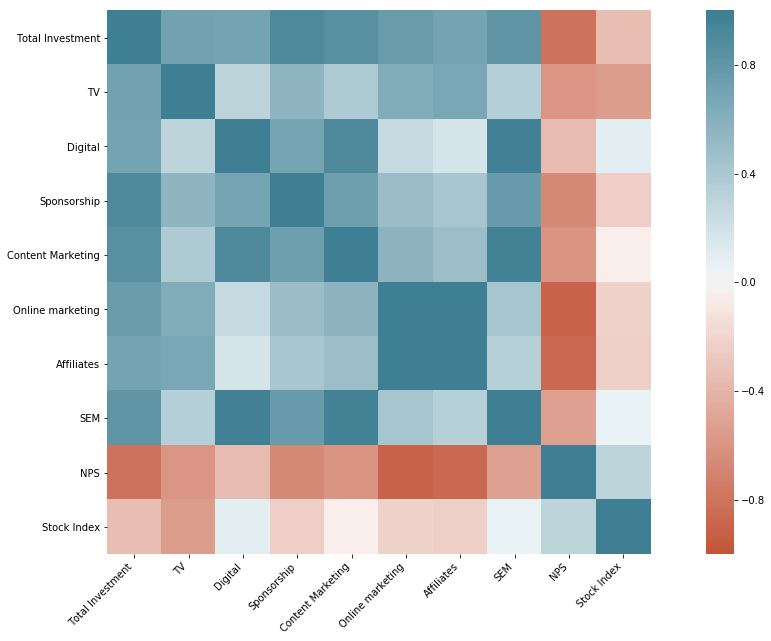

In [36]:
corr = investment_df.drop(['Year', 'Month'], axis=1).corr()


ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [37]:
# Finding top 10 correlations
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
def get_top_abs_correlations(df, n):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

get_top_abs_correlations(investment_df.drop(['Year', 'Month'], axis=1), 10)

Online marketing   Affiliates           0.989232
Digital            SEM                  0.971979
Content Marketing  SEM                  0.959735
Digital            Content Marketing    0.901355
Total Investment   Sponsorship          0.899030
Online marketing   NPS                  0.885533
Affiliates         NPS                  0.863585
Total Investment   Content Marketing    0.856087
                   NPS                  0.818619
                   SEM                  0.810724
dtype: float64

In [38]:
# drop columns with correlation coefficient greater than 0.95
col_to_drop=['Affiliates','SEM']
investment_df.drop(col_to_drop, axis=1, inplace=True)
investment_df.columns

Index(['Year', 'Month', 'Total Investment', 'TV', 'Digital', 'Sponsorship',
       'Content Marketing', 'Online marketing', 'NPS', 'Stock Index'],
      dtype='object')

### merging investment data with all 3 sub category dataframes


In [39]:
camera_investment_df=pd.merge(weekly_CameraAccessory_df.reset_index(), investment_df, how='inner', left_on=['Year','Month'], right_on=['Year','Month'])
camera_investment_df.head()

,Year,order_week,Month,gmv,units,s1_fact.order_payment_type,sla,product_mrp,product_procurement_sla,holiday_flag,payday_flag,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,NPS,Stock Index
0,2015,27,7,15526.0,25,Prepaid,1.840000,1458.040000,2.920000,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177
1,2015,28,7,3702743.0,2653,COD,6.302637,2567.004723,2.672176,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177
2,2015,29,7,4203216.0,2957,COD,5.999651,2519.958871,2.694667,1,1,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177
3,2015,30,7,4141102.0,2978,COD,6.095905,2493.424221,2.737137,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177
4,2015,31,7,2709387.0,1988,COD,6.043661,2425.002104,2.723304,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177


In [40]:
homeAudio_investment_df=pd.merge(weekly_HomeAudio_df.reset_index(), investment_df, how='inner', left_on=['Year','Month'], right_on=['Year','Month'])
homeAudio_investment_df.head()

,Year,order_week,Month,gmv,units,s1_fact.order_payment_type,sla,product_mrp,product_procurement_sla,holiday_flag,payday_flag,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,NPS,Stock Index
0,2015,27,7,1.067560e+05,38,Prepaid,2.789474,4642.473684,3.605263,0,1,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177
1,2015,28,7,3.931992e+06,1756,COD,6.302926,3463.745841,2.865175,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177
2,2015,29,7,4.809561e+06,2162,COD,6.202143,3577.937587,2.730787,1,1,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177
3,2015,30,7,4.181413e+06,1994,COD,6.357468,3420.401013,2.856203,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177
4,2015,31,7,3.028711e+06,1409,COD,6.432143,3488.468571,2.720714,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177


In [41]:
gamingAccessory_investment_df=pd.merge(weekly_GamingAccessory_df.reset_index(), investment_df, how='inner', left_on=['Year','Month'], right_on=['Year','Month'])
gamingAccessory_investment_df.head()

,Year,order_week,Month,gmv,units,s1_fact.order_payment_type,sla,product_mrp,product_procurement_sla,holiday_flag,payday_flag,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,NPS,Stock Index
0,2015,27,7,3.688800e+04,29,Prepaid,2.758621,1850.275862,2.586207,0,1,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177
1,2015,28,7,2.553872e+06,2852,COD,5.043655,1480.089900,3.153903,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177
2,2015,29,7,2.166214e+06,2842,COD,5.174701,1295.536444,2.596606,1,1,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177
3,2015,30,7,2.505570e+06,2462,COD,5.331075,1673.855631,2.439881,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177
4,2015,31,7,1.770605e+06,1678,COD,5.719773,1861.376574,2.394207,0,1,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177


### Importing Climate Data

In [42]:
climate_df_2015=pd.read_excel ('ONTARIO-2015.xlsx',
                               sheet_name='Data',
                             usecols = "A:M",
                              header=[0],
                              
                                )
climate_df_2015.shape

(365, 13)

In [43]:
climate_df_2016=pd.read_excel ('ONTARIO-2016.xlsx',
                               sheet_name='Data',
                             usecols = "A:M",
                              header=[0],
                              
                                )
climate_df_2016.shape

(366, 13)

In [44]:
climate_clubbed=pd.concat([climate_df_2015,climate_df_2016])
climate_clubbed.shape

(731, 13)

In [45]:
climate_clubbed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 0 to 365
Data columns (total 13 columns):
Date/Time             731 non-null datetime64[ns]
Year                  731 non-null int64
Month                 731 non-null int64
Day                   731 non-null int64
Max Temp (°C)         442 non-null float64
Min Temp (°C)         409 non-null float64
Mean Temp (°C)        409 non-null float64
Heat Deg Days (°C)    409 non-null float64
Cool Deg Days (°C)    409 non-null float64
Total Rain (mm)       456 non-null float64
Total Snow (cm)       456 non-null float64
Total Precip (mm)     456 non-null float64
Snow on Grnd (cm)     456 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(3)
memory usage: 80.0 KB


In [46]:
# extracting week from Date/Time
climate_clubbed['Week']=climate_clubbed['Date/Time'].dt.week

In [47]:
# drop coloumn Date/Time
climate_clubbed=climate_clubbed.drop(['Date/Time'], axis=1)

In [48]:
# drop column Month and Day
climate_clubbed=climate_clubbed.drop(['Month','Day'], axis=1)

In [49]:
climate_clubbed.columns

Index(['Year', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
       'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)',
       'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)', 'Week'],
      dtype='object')

#### Missing values treatment

In [50]:
# Replacing NAN with ffill and bfill
climate_clubbed = climate_clubbed.fillna(method='ffill').fillna(method='bfill')

In [51]:
climate_clubbed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 0 to 365
Data columns (total 11 columns):
Year                  731 non-null int64
Max Temp (°C)         731 non-null float64
Min Temp (°C)         731 non-null float64
Mean Temp (°C)        731 non-null float64
Heat Deg Days (°C)    731 non-null float64
Cool Deg Days (°C)    731 non-null float64
Total Rain (mm)       731 non-null float64
Total Snow (cm)       731 non-null float64
Total Precip (mm)     731 non-null float64
Snow on Grnd (cm)     731 non-null float64
Week                  731 non-null int64
dtypes: float64(9), int64(2)
memory usage: 68.5 KB


#### Finding correlation among various features

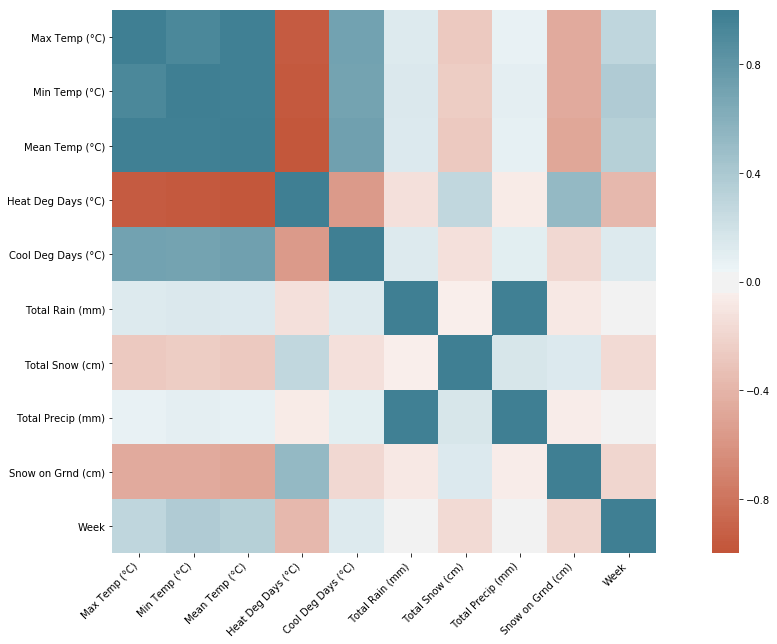

In [52]:
corr = climate_clubbed.drop(['Year'], axis=1).corr()


ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [53]:
get_top_abs_correlations(climate_clubbed.drop(['Year'], axis=1), 10)

Total Rain (mm)  Total Precip (mm)     0.980551
Min Temp (°C)    Mean Temp (°C)        0.978927
Mean Temp (°C)   Heat Deg Days (°C)    0.976756
Max Temp (°C)    Mean Temp (°C)        0.976678
Min Temp (°C)    Heat Deg Days (°C)    0.956062
Max Temp (°C)    Heat Deg Days (°C)    0.951702
                 Min Temp (°C)         0.918680
Mean Temp (°C)   Cool Deg Days (°C)    0.724980
Max Temp (°C)    Cool Deg Days (°C)    0.715378
Min Temp (°C)    Cool Deg Days (°C)    0.710062
dtype: float64

In [54]:
# Drop columns having correlation coefficient >0.95
col_to_drop=['Total Precip (mm)','Heat Deg Days (°C)','Mean Temp (°C)']
climate_clubbed.drop(col_to_drop, axis=1, inplace=True)
climate_clubbed.columns

Index(['Year', 'Max Temp (°C)', 'Min Temp (°C)', 'Cool Deg Days (°C)',
       'Total Rain (mm)', 'Total Snow (cm)', 'Snow on Grnd (cm)', 'Week'],
      dtype='object')

#### Converting Daily Climate Data to Weekly

In [55]:
weekly_climate_data=climate_clubbed.groupby(['Year','Week']).mean()

weekly_climate_data.head()

Max Temp (°C)  Min Temp (°C)  Cool Deg Days (°C)  Total Rain (mm)  \
Year Week                                                                      
2015 1          2.000000      -3.875000                 0.0         6.000000   
     2         -7.428571     -13.714286                 0.0         0.000000   
     3         -8.214286     -14.714286                 0.0         0.171429   
     4         -2.000000      -5.428571                 0.0         0.000000   
     5         -1.000000     -10.500000                 0.0         0.000000   

           Total Snow (cm)  Snow on Grnd (cm)  
Year Week                                      
2015 1            0.250000           0.000000  
     2            1.714286           1.142857  
     3            0.000000           2.571429  
     4            0.000000           2.285714  
     5            2.857143           2.428571

### Merging weekly climate data with all 3 subcategory data and investment data

In [56]:
master_cameraAccessory_df=pd.merge(camera_investment_df, weekly_climate_data.reset_index(), how='inner', left_on=['Year','order_week'], right_on=['Year','Week']).drop(['Week'], axis='columns')
master_cameraAccessory_df.head()

,Year,order_week,Month,gmv,units,s1_fact.order_payment_type,sla,product_mrp,product_procurement_sla,holiday_flag,payday_flag,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,NPS,Stock Index,Max Temp (°C),Min Temp (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Snow on Grnd (cm)
0,2015,27,7,15526.0,25,Prepaid,1.840000,1458.040000,2.920000,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,25.428571,14.000000,1.800000,0.600000,0.0,0.0
1,2015,28,7,3702743.0,2653,COD,6.302637,2567.004723,2.672176,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,25.285714,15.142857,2.471429,3.785714,0.0,0.0
2,2015,29,7,4203216.0,2957,COD,5.999651,2519.958871,2.694667,1,1,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,28.214286,17.642857,4.942857,1.200000,0.0,0.0
3,2015,30,7,4141102.0,2978,COD,6.095905,2493.424221,2.737137,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,29.785714,16.142857,4.828571,0.771429,0.0,0.0
4,2015,31,7,2709387.0,1988,COD,6.043661,2425.002104,2.723304,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,31.857143,17.500000,6.700000,3.971429,0.0,0.0


In [57]:
# Lets make order_week for year 2016 in continuation with 2015 and drop Year and Month
# last week of 2015 is 53 so 1st week of 2016 will be 54
mask =  (master_cameraAccessory_df['Year']==2016)
master_cameraAccessory_df['order_week'][mask] =master_cameraAccessory_df['order_week']+53
master_cameraAccessory_df[master_cameraAccessory_df.Year==2016].head()

/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Year,order_week,Month,gmv,units,s1_fact.order_payment_type,sla,product_mrp,product_procurement_sla,holiday_flag,payday_flag,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,NPS,Stock Index,Max Temp (°C),Min Temp (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Snow on Grnd (cm)
26,2016,54,1,4862401.0,5137,COD,5.584164,1760.670921,2.820303,0,0,74.196,4.38,0.456,4.2,0.9,22.9,47.093031,1052,6.071429,-3.428571,0.0,3.371429,1.0,0.000000
27,2016,55,1,4027769.0,3665,COD,6.224109,1977.756682,2.616927,0,1,74.196,4.38,0.456,4.2,0.9,22.9,47.093031,1052,0.642857,-6.500000,0.0,3.257143,1.0,8.428571
28,2016,56,1,6624939.0,4960,COD,6.061532,2299.398100,2.634937,1,0,74.196,4.38,0.456,4.2,0.9,22.9,47.093031,1052,1.071429,-2.000000,0.0,3.257143,0.0,3.428571
29,2016,57,1,4677940.0,3418,COD,6.358254,2310.638158,2.554725,0,0,74.196,4.38,0.456,4.2,0.9,22.9,47.093031,1052,5.928571,-9.000000,0.0,0.000000,0.0,0.000000
30,2016,106,1,2213408.0,1858,COD,6.043430,1991.908741,2.744915,1,1,74.196,4.38,0.456,4.2,0.9,22.9,47.093031,1052,6.500000,-2.000000,0.0,0.000000,0.0,0.000000


In [58]:
master_cameraAccessory_df=master_cameraAccessory_df.drop(['Year','Month'], axis=1)

In [59]:
master_homeAudio_df=pd.merge(homeAudio_investment_df, weekly_climate_data.reset_index(), how='inner', left_on=['Year','order_week'], right_on=['Year','Week']).drop(['Week'], axis='columns')
master_homeAudio_df.head()

,Year,order_week,Month,gmv,units,s1_fact.order_payment_type,sla,product_mrp,product_procurement_sla,holiday_flag,payday_flag,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,NPS,Stock Index,Max Temp (°C),Min Temp (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Snow on Grnd (cm)
0,2015,27,7,1.067560e+05,38,Prepaid,2.789474,4642.473684,3.605263,0,1,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,25.428571,14.000000,1.800000,0.600000,0.0,0.0
1,2015,28,7,3.931992e+06,1756,COD,6.302926,3463.745841,2.865175,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,25.285714,15.142857,2.471429,3.785714,0.0,0.0
2,2015,29,7,4.809561e+06,2162,COD,6.202143,3577.937587,2.730787,1,1,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,28.214286,17.642857,4.942857,1.200000,0.0,0.0
3,2015,30,7,4.181413e+06,1994,COD,6.357468,3420.401013,2.856203,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,29.785714,16.142857,4.828571,0.771429,0.0,0.0
4,2015,31,7,3.028711e+06,1409,COD,6.432143,3488.468571,2.720714,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,31.857143,17.500000,6.700000,3.971429,0.0,0.0


In [60]:
mask =  (master_homeAudio_df['Year']==2016)
master_homeAudio_df['order_week'][mask] =master_homeAudio_df['order_week']+53
master_homeAudio_df=master_homeAudio_df.drop(['Year','Month'], axis=1)

/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [61]:
master_gamingAccessory_df=pd.merge(gamingAccessory_investment_df, weekly_climate_data.reset_index(), how='inner', left_on=['Year','order_week'], right_on=['Year','Week']).drop(['Week'], axis='columns')
master_gamingAccessory_df.head()

,Year,order_week,Month,gmv,units,s1_fact.order_payment_type,sla,product_mrp,product_procurement_sla,holiday_flag,payday_flag,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,NPS,Stock Index,Max Temp (°C),Min Temp (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Snow on Grnd (cm)
0,2015,27,7,3.688800e+04,29,Prepaid,2.758621,1850.275862,2.586207,0,1,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,25.428571,14.000000,1.800000,0.600000,0.0,0.0
1,2015,28,7,2.553872e+06,2852,COD,5.043655,1480.089900,3.153903,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,25.285714,15.142857,2.471429,3.785714,0.0,0.0
2,2015,29,7,2.166214e+06,2842,COD,5.174701,1295.536444,2.596606,1,1,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,28.214286,17.642857,4.942857,1.200000,0.0,0.0
3,2015,30,7,2.505570e+06,2462,COD,5.331075,1673.855631,2.439881,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,29.785714,16.142857,4.828571,0.771429,0.0,0.0
4,2015,31,7,1.770605e+06,1678,COD,5.719773,1861.376574,2.394207,0,1,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,31.857143,17.500000,6.700000,3.971429,0.0,0.0


In [62]:
mask =  (master_gamingAccessory_df['Year']==2016)
master_gamingAccessory_df['order_week'][mask] =master_gamingAccessory_df['order_week']+53
master_gamingAccessory_df=master_gamingAccessory_df.drop(['Year','Month'], axis=1)

/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [63]:
# replacing Prepaid with 1 and COD with 0 in s1_fact.order_payment_type in all 3 master files
# Defining the map function
def binary_map(x):
    return x.map({'Prepaid': 1, "COD": 0})

master_cameraAccessory_df[['s1_fact.order_payment_type']] = master_cameraAccessory_df[['s1_fact.order_payment_type']].apply(binary_map)

In [64]:
master_homeAudio_df[['s1_fact.order_payment_type']] = master_homeAudio_df[['s1_fact.order_payment_type']].apply(binary_map)
master_gamingAccessory_df[['s1_fact.order_payment_type'] ]= master_gamingAccessory_df[['s1_fact.order_payment_type']].apply(binary_map)

In [65]:
master_cameraAccessory_df.head()

,order_week,gmv,units,s1_fact.order_payment_type,sla,product_mrp,product_procurement_sla,holiday_flag,payday_flag,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,NPS,Stock Index,Max Temp (°C),Min Temp (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Snow on Grnd (cm)
0,27,15526.0,25,1,1.840000,1458.040000,2.920000,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,25.428571,14.000000,1.800000,0.600000,0.0,0.0
1,28,3702743.0,2653,0,6.302637,2567.004723,2.672176,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,25.285714,15.142857,2.471429,3.785714,0.0,0.0
2,29,4203216.0,2957,0,5.999651,2519.958871,2.694667,1,1,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,28.214286,17.642857,4.942857,1.200000,0.0,0.0
3,30,4141102.0,2978,0,6.095905,2493.424221,2.737137,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,29.785714,16.142857,4.828571,0.771429,0.0,0.0
4,31,2709387.0,1988,0,6.043661,2425.002104,2.723304,0,0,17.061775,0.21533,2.533014,7.41427,0.000933,1.327278,54.599588,1177,31.857143,17.500000,6.700000,3.971429,0.0,0.0


In [66]:
master_cameraAccessory_df.shape

(53, 23)

## Modelling

## 1.  Camera Accessory

#### train test split

In [67]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_cam_train, df_cam_test = train_test_split(master_cameraAccessory_df, train_size = 0.7, test_size = 0.3, random_state = 100)

#### Rescaling the features

In [68]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [69]:
# Apply scaler() to all the numeric columns except the flag variables
print(master_cameraAccessory_df.columns)

Index(['order_week', 'gmv', 'units', 's1_fact.order_payment_type', 'sla',
       'product_mrp', 'product_procurement_sla', 'holiday_flag', 'payday_flag',
       'Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing', 'NPS', 'Stock Index', 'Max Temp (°C)',
       'Min Temp (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)',
       'Total Snow (cm)', 'Snow on Grnd (cm)'],
      dtype='object')


In [70]:
num_vars = ['order_week', 'gmv', 'units', 's1_fact.order_payment_type', 'sla',
       'product_mrp', 'product_procurement_sla','Total Investment', 'TV','Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing','NPS', 'Stock Index','Max Temp (°C)','Min Temp (°C)',
       'Cool Deg Days (°C)','Total Rain (mm)',
       'Total Snow (cm)', 'Snow on Grnd (cm)']

df_cam_train[num_vars] = scaler.fit_transform(df_cam_train[num_vars])

/Users/venramam/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [71]:
df_cam_train.head()

,order_week,gmv,units,s1_fact.order_payment_type,sla,product_mrp,product_procurement_sla,holiday_flag,payday_flag,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,NPS,Stock Index,Max Temp (°C),Min Temp (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Snow on Grnd (cm)
26,0.333333,0.387534,0.493938,0.0,0.319510,0.531611,0.888613,0,0,0.418747,0.470601,0.000000,0.037516,0.261317,0.939289,0.172859,0.162996,0.173516,0.201031,0.0,0.244306,0.70,0.00000
41,0.512821,0.339344,0.420131,1.0,0.326698,0.591127,0.608286,0,1,0.313667,0.559394,0.034183,0.278020,0.010124,0.675889,0.476577,1.000000,0.470320,0.332474,0.0,0.000000,0.44,0.00000
28,0.358974,0.528061,0.476905,0.0,0.489068,0.813446,0.763855,1,0,0.418747,0.470601,0.000000,0.037516,0.261317,0.939289,0.172859,0.162996,0.013699,0.252577,0.0,0.236025,0.00,0.40678
38,0.474359,0.345426,0.454196,0.0,0.297408,0.513554,0.631800,0,0,0.575196,1.000000,0.135125,0.484715,0.107429,0.755225,0.296507,0.000000,0.363014,0.291237,0.0,1.000000,0.00,0.00000
17,0.217949,0.442133,0.453329,0.0,0.404189,0.761399,0.904384,1,0,0.279553,0.453453,0.067355,0.156786,0.048962,0.801580,0.166891,0.960352,0.554795,0.626289,0.0,0.118012,0.00,0.00000


### Base Linear Model using RFE for Camera Accessory

In [72]:
y_train = df_cam_train.pop('gmv')
X_train = df_cam_train

In [73]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [74]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 10)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [75]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('order_week', False, 2),
 ('units', True, 1),
 ('s1_fact.order_payment_type', False, 12),
 ('sla', True, 1),
 ('product_mrp', True, 1),
 ('product_procurement_sla', False, 7),
 ('holiday_flag', False, 5),
 ('payday_flag', False, 9),
 ('Total Investment', True, 1),
 ('TV', True, 1),
 ('Digital', True, 1),
 ('Sponsorship', True, 1),
 ('Content Marketing', True, 1),
 ('Online marketing', False, 13),
 ('NPS', False, 6),
 ('Stock Index', False, 11),
 ('Max Temp (°C)', True, 1),
 ('Min Temp (°C)', False, 4),
 ('Cool Deg Days (°C)', False, 3),
 ('Total Rain (mm)', True, 1),
 ('Total Snow (cm)', False, 10),
 ('Snow on Grnd (cm)', False, 8)]

In [76]:
col = X_train.columns[rfe.support_]
col

Index(['units', 'sla', 'product_mrp', 'Total Investment', 'TV', 'Digital',
       'Sponsorship', 'Content Marketing', 'Max Temp (°C)', 'Total Rain (mm)'],
      dtype='object')

In [77]:
X_train.columns[~rfe.support_]

Index(['order_week', 's1_fact.order_payment_type', 'product_procurement_sla',
       'holiday_flag', 'payday_flag', 'Online marketing', 'NPS', 'Stock Index',
       'Min Temp (°C)', 'Cool Deg Days (°C)', 'Total Snow (cm)',
       'Snow on Grnd (cm)'],
      dtype='object')

#### Building model using statsmodel, for the detailed statistics

In [78]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [79]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

/Users/venramam/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [80]:
lm = sm.OLS(y_train,X_train_rfe).fit() 

In [81]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     123.1
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           2.79e-19
Time:                        21:05:34   Log-Likelihood:                 82.705
No. Observations:                  37   AIC:                            -143.4
Df Residuals:                      26   BIC:                            -125.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3034      0.04

In [82]:
# Total Rain (mm) is insignificant in presence of other variables aand can be dropped
X_train_new = X_train_rfe.drop(["Total Rain (mm)"], axis = 1)

In [83]:
# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)

In [84]:
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     139.8
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           2.79e-20
Time:                        21:05:34   Log-Likelihood:                 82.413
No. Observations:                  37   AIC:                            -144.8
Df Residuals:                      27   BIC:                            -128.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.2967      0.04

In [85]:
X_train_lm=X_train_lm.drop(['const'], axis=1)

# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_lm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,Total Investment,1961.64
7,Content Marketing,701.01
4,TV,199.27
6,Sponsorship,159.83
5,Digital,150.44
2,product_mrp,26.05
8,Max Temp (°C),22.01
0,units,8.90
1,sla,6.94


In [86]:
# Total Investment has very high VIF, lets drop it and rebuild it again 
X_train_new1 = X_train_new.drop(["Total Investment"], axis = 1)
X_train_lm = sm.add_constant(X_train_new1)
lm = sm.OLS(y_train,X_train_lm).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     121.4
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           1.16e-19
Time:                        21:05:34   Log-Likelihood:                 77.082
No. Observations:                  37   AIC:                            -136.2
Df Residuals:                      28   BIC:                            -121.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3492      0.05

/Users/venramam/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [87]:
# Sponsorship is insignificant in presence of other variables lets drop it
X_train_new2 = X_train_new1.drop(["Sponsorship"], axis = 1)
X_train_lm = sm.add_constant(X_train_new2)
lm = sm.OLS(y_train,X_train_lm).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     143.1
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           9.75e-21
Time:                        21:05:34   Log-Likelihood:                 77.015
No. Observations:                  37   AIC:                            -138.0
Df Residuals:                      29   BIC:                            -125.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3572      0.04

In [88]:
# Content Marketing is insignificant lets drop it and rebuild
X_train_new3 = X_train_new2.drop(["Content Marketing"], axis = 1)
X_train_lm = sm.add_constant(X_train_new3)
lm = sm.OLS(y_train,X_train_lm).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     146.8
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           7.45e-21
Time:                        21:05:34   Log-Likelihood:                 74.096
No. Observations:                  37   AIC:                            -134.2
Df Residuals:                      30   BIC:                            -122.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.3477      0.045     -7.750

In [89]:

X_train_new3=X_train_new3.drop(columns=['const'])
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new3
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,product_mrp,13.76
0,units,7.17
3,TV,6.21
1,sla,5.75
5,Max Temp (°C),5.49
4,Digital,1.71


##### still product_mrp is having liitle high vif, but I think this is an important kpi so we are not dropping it.
##### Important KPIs : product_mrp,units,TV, sla, Max Temp (°C), Digital

### Koyck Model for Camera Accessory

In [90]:
master_cameraAccessory_koyck=master_cameraAccessory_df.copy()
master_cameraAccessory_koyck['lag gmv']=master_cameraAccessory_koyck['gmv'].shift(1)

In [91]:
# For 1st row lag gmv would be NAN, lets exclude this row for analysis
master_cameraAccessory_koyck=master_cameraAccessory_koyck.loc[1:,:]

In [92]:
np.random.seed(0)
df_cam_train, df_cam_test = train_test_split(master_cameraAccessory_koyck, train_size = 0.7, test_size = 0.3, random_state = 100)

In [93]:
scaler = MinMaxScaler()

In [94]:
num_vars = ['order_week','lag gmv', 'gmv', 'units', 's1_fact.order_payment_type', 'sla',
       'product_mrp', 'product_procurement_sla','Total Investment', 'TV','Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing','NPS', 'Stock Index','Max Temp (°C)','Min Temp (°C)',
       'Cool Deg Days (°C)','Total Rain (mm)',
       'Total Snow (cm)', 'Snow on Grnd (cm)']

df_cam_train[num_vars] = scaler.fit_transform(df_cam_train[num_vars])

/Users/venramam/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [95]:
y_train = df_cam_train.pop('gmv')
X_train = df_cam_train

In [96]:
selected_kpi=['product_mrp','units','TV', 'sla', 'Max Temp (°C)', 'Digital','lag gmv']
lm = LinearRegression()
lm.fit(X_train[selected_kpi], y_train)
from sklearn import metrics
# predict
y_train_pred = lm.predict(X_train[selected_kpi])
metrics.r2_score(y_true=y_train, y_pred=y_train_pred)

0.9662393022589325

In [97]:
df_cam_test[num_vars] = scaler.transform(df_cam_test[num_vars])
y_test = df_cam_test.pop('gmv')
X_test = df_cam_test

/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [98]:
y_test_pred = lm.predict(X_test[selected_kpi])
metrics.r2_score(y_true=y_test, y_pred=y_test_pred)

0.9531121879085832

In [99]:
# model coefficients
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_test[selected_kpi].columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', -0.316),
 ('product_mrp', 0.303),
 ('units', 0.878),
 ('TV', 0.054),
 ('sla', 0.187),
 ('Max Temp (°C)', 0.065),
 ('Digital', -0.039),
 ('lag gmv', -0.037)]

Train and Test accuracy are quite close and we have good R-square value (0.96) for the model

In [100]:
# lasso regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
lm = Lasso(alpha=0.001)
lm.fit(X_train[selected_kpi], y_train)

# predict
y_train_pred = lm.predict(X_train[selected_kpi])
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lm.predict(X_test[selected_kpi])
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.9584017793303675
0.9479360640763062


In [101]:
# lasso model parameters
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_train[selected_kpi].columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', -0.209),
 ('product_mrp', 0.269),
 ('units', 0.848),
 ('TV', 0.0),
 ('sla', 0.107),
 ('Max Temp (°C)', 0.018),
 ('Digital', -0.0),
 ('lag gmv', -0.0)]

In [102]:
# grid search CV

# set up cross validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
params = {'alpha': [0.001, 0.01, 1.0, 5.0, 10.0]}

# grid search
# lasso model
model = Lasso()
model_cv = GridSearchCV(estimator = model, param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True, verbose = 1)            
model_cv.fit(X_train[selected_kpi], y_train) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
/Users/venramam/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.001, 0.01, 1.0, 5.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [103]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003402,0.000397,0.001742,0.000404,0.001,{'alpha': 0.001},0.969935,0.902440,0.864839,0.849754,0.925038,0.904277,0.043851,1,0.954621,0.965162,0.969216,0.964178,0.963617,0.963359,0.004788
1,0.002156,0.000194,0.001012,0.000171,0.01,{'alpha': 0.01},0.841523,0.698225,0.672373,0.706261,0.690060,0.725017,0.063252,2,0.791668,0.834969,0.617635,0.851390,0.837749,0.786682,0.086866
2,0.001873,0.000260,0.000937,0.000145,1,{'alpha': 1.0},-0.003043,-0.048046,-0.000605,-0.160587,-0.003264,-0.041996,0.060858,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.001623,0.000045,0.000883,0.000054,5,{'alpha': 5.0},-0.003043,-0.048046,-0.000605,-0.160587,-0.003264,-0.041996,0.060858,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.001867,0.000248,0.000896,0.000052,10,{'alpha': 10.0},-0.003043,-0.048046,-0.000605,-0.160587,-0.003264,-0.041996,0.060858,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


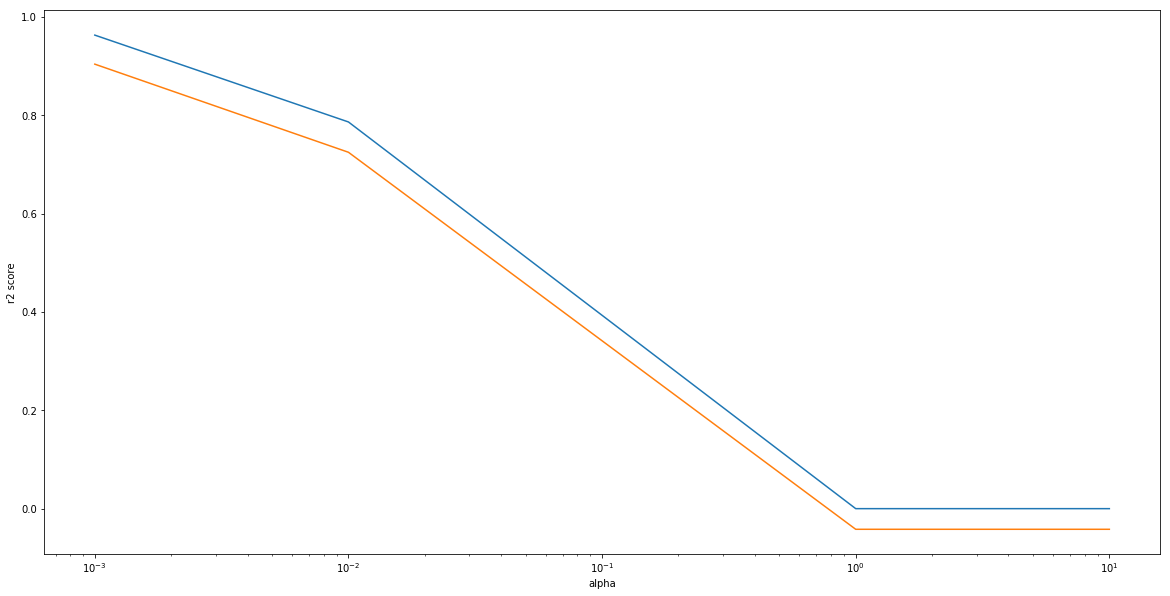

In [104]:
# plot
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

In [105]:
# model with optimal alpha
# lasso regression

lm = Lasso(alpha=.001)
lm.fit(X_train[selected_kpi], y_train)

# predict
y_train_pred = lm.predict(X_train[selected_kpi])
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lm.predict(X_test[selected_kpi])
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.9584017793303675
0.9479360640763062


### Distributed Lag Model for Camera Accessory

In [106]:
# adding lag for all the independent variables also- 'product_mrp','units','TV', 'sla', 'Max Temp (°C)', 'Digital'

master_cameraAccessory_dlag=master_cameraAccessory_df.copy()

master_cameraAccessory_dlag['lag gmv']=master_cameraAccessory_dlag['gmv'].shift(1)
master_cameraAccessory_dlag['lag product_mrp']=master_cameraAccessory_dlag['product_mrp'].shift(1)
master_cameraAccessory_dlag['lag units']=master_cameraAccessory_dlag['units'].shift(1)
master_cameraAccessory_dlag['lag TV']=master_cameraAccessory_dlag['TV'].shift(1)
master_cameraAccessory_dlag['lag sla']=master_cameraAccessory_dlag['sla'].shift(1)
master_cameraAccessory_dlag['lag Max Temp (°C)']=master_cameraAccessory_dlag['Max Temp (°C)'].shift(1)
master_cameraAccessory_dlag['lag Digital']=master_cameraAccessory_dlag['Digital'].shift(1)

In [107]:
# For 1st row lag variables would be NAN, lets exclude this row for analysis
master_cameraAccessory_dlag=master_cameraAccessory_dlag.loc[1:,:]

In [108]:
np.random.seed(0)
df_cam_train, df_cam_test = train_test_split(master_cameraAccessory_dlag, train_size = 0.7, test_size = 0.3, random_state = 100)

In [109]:
num_vars = ['order_week','lag gmv', 'gmv', 'lag units','units', 's1_fact.order_payment_type', 'lag sla','sla','lag product_mrp',
            'product_mrp', 'product_procurement_sla','Total Investment','lag TV', 'TV','lag Digital','Digital', 'Sponsorship',
            'Content Marketing','Online marketing','NPS', 'Stock Index','lag Max Temp (°C)','Max Temp (°C)','Min Temp (°C)',
       'Cool Deg Days (°C)','Total Rain (mm)',
       'Total Snow (cm)', 'Snow on Grnd (cm)']

df_cam_train[num_vars] = scaler.fit_transform(df_cam_train[num_vars])

/Users/venramam/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [110]:
y_train = df_cam_train.pop('gmv')
X_train = df_cam_train

In [111]:
selected_kpi=['lag product_mrp','product_mrp','lag units','units','lag TV','TV','lag sla', 'sla', 'lag Max Temp (°C)',
              'Max Temp (°C)', 'lag Digital','Digital','lag gmv']
lm = LinearRegression()
lm.fit(X_train[selected_kpi], y_train)
from sklearn import metrics
# predict
y_train_pred = lm.predict(X_train[selected_kpi])
metrics.r2_score(y_true=y_train, y_pred=y_train_pred)

0.9693429982236222

In [112]:
df_cam_test[num_vars] = scaler.transform(df_cam_test[num_vars])
y_test = df_cam_test.pop('gmv')
X_test = df_cam_test

/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [113]:
y_test_pred = lm.predict(X_test[selected_kpi])
metrics.r2_score(y_true=y_test, y_pred=y_test_pred)

0.9504920655372002

In [114]:
# model coefficients
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_test[selected_kpi].columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', -0.312),
 ('lag product_mrp', 0.039),
 ('product_mrp', 0.259),
 ('lag units', -0.098),
 ('units', 0.906),
 ('lag TV', -0.012),
 ('TV', 0.055),
 ('lag sla', 0.048),
 ('sla', 0.142),
 ('lag Max Temp (°C)', -0.018),
 ('Max Temp (°C)', 0.074),
 ('lag Digital', -0.006),
 ('Digital', -0.029),
 ('lag gmv', 0.061)]

Distributed lag model is having even higher accuracy and is taking account lag effect of all the independent and dependent variables

### Multiplicative Model for Camera Accessory

In [115]:
# taking log of all the dependent and independent variables
master_cameraAccessory_multiplicative = master_cameraAccessory_df.copy()
master_cameraAccessory_multiplicative = master_cameraAccessory_multiplicative.apply(lambda x: np.log(x) if np.issubdtype(x.dtype, np.number) else x)

/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [116]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_cam_train, df_cam_test = train_test_split(master_cameraAccessory_multiplicative, train_size = 0.7, test_size = 0.3, random_state = 100)

# Rescaling the features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()



# Apply scaler() to all the numeric columns except the flag variables
print(master_cameraAccessory_multiplicative.columns)

# excluding 's1_fact.order_payment_type',holiday_flag and payday_flag as there are many values as 0 in such data
# when taking log it turns to be infinity
num_vars = ['order_week', 'gmv', 'units', 'sla',
       'product_mrp', 'product_procurement_sla','Total Investment', 'TV','Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing','NPS', 'Stock Index','Max Temp (°C)','Min Temp (°C)']
#       'Cool Deg Days (°C)','Total Rain (mm)',
#       'Total Snow (cm)', 'Snow on Grnd (cm)']

df_cam_train[num_vars] = scaler.fit_transform(df_cam_train[num_vars])


### Base Linear Model using RFE
## Replacing the inf values with mean values of the columns
y_train = df_cam_train.pop('gmv')
df_cam_train = df_cam_train.replace([np.inf, -np.inf], np.nan)
df_cam_train.fillna(df_cam_train.mean(), inplace=True)
X_train = df_cam_train


# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 10)             # running RFE
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

col = X_train.columns[rfe.support_]
col

X_train.columns[~rfe.support_]

#### Building model using statsmodel, for the detailed statistics

# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train,X_train_rfe).fit()  

#Let's see the summary of our linear model
print(lm.summary())

/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index(['order_week', 'gmv', 'units', 's1_fact.order_payment_type', 'sla',
       'product_mrp', 'product_procurement_sla', 'holiday_flag', 'payday_flag',
       'Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing', 'NPS', 'Stock Index', 'Max Temp (°C)',
       'Min Temp (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)',
       'Total Snow (cm)', 'Snow on Grnd (cm)'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5194.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           2.92e-40
Time:                        21:05:42   Log-Likelihood:                 157.99
No. Observations:                  37   AIC:                            -294.0
Df Residuals

/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_array(key, value)
/Users/venramam/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


###### R-Squared and Adj R-squared are valued as perfect 1, which might be overfitting model

In [117]:
X_train_rfe = X_train_rfe.drop(["Online marketing"], axis = 1)
X_train_lm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_lm).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5961.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           3.92e-42
Time:                        21:05:42   Log-Likelihood:                 157.88
No. Observations:                  37   AIC:                            -295.8
Df Residuals:                      27   BIC:                            -279.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [118]:
X_train_rfe = X_train_rfe.drop(["Total Investment"], axis = 1)
X_train_lm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_lm).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     6953.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           4.52e-44
Time:                        21:05:42   Log-Likelihood:                 157.88
No. Observations:                  37   AIC:                            -297.8
Df Residuals:                      28   BIC:                            -283.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [119]:
X_train_rfe = X_train_rfe.drop(["Sponsorship"], axis = 1)
X_train_lm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_lm).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     7149.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           3.67e-45
Time:                        21:05:42   Log-Likelihood:                 155.28
No. Observations:                  37   AIC:                            -294.6
Df Residuals:                      29   BIC:                            -281.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [120]:
# Now all the kpis have low p value so all are important, lets check vif
X_train_lm=X_train_lm.drop(['const'], axis=1)

# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_lm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,units,145.23
3,product_mrp,121.23
4,product_procurement_sla,119.62
5,TV,60.10
0,order_week,9.62
2,sla,6.89
6,Total Snow (cm),2.29


##### Here we can conclude that Multiplicative Model alwasy gives R-squared and Adj. R-Squared as perfect 1, which does not bring out the perfect model that can be suggested to the Client.

## Model for Home Audio 

### Base Linear model for Home Audio

In [121]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_audio_train, df_audio_test = train_test_split(master_homeAudio_df, train_size = 0.7, test_size = 0.3, random_state = 100)

# Rescaling the features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Apply scaler() to all the numeric columns except the flag variables


num_vars = ['order_week', 'gmv', 'units', 's1_fact.order_payment_type', 'sla',
       'product_mrp', 'product_procurement_sla','Total Investment', 'TV','Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing','NPS', 'Stock Index','Max Temp (°C)','Min Temp (°C)',
       'Cool Deg Days (°C)','Total Rain (mm)',
       'Total Snow (cm)', 'Snow on Grnd (cm)']

df_audio_train[num_vars] = scaler.fit_transform(df_audio_train[num_vars])


### Base Linear Model using RFE

y_train = df_audio_train.pop('gmv')
X_train = df_audio_train

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 10)             # running RFE
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

col = X_train.columns[rfe.support_]
col

X_train.columns[~rfe.support_]

#### Building model using statsmodel, for the detailed statistics

# Creating X_train dataframe with RFE selected variables
X_train_rfe = X_train[col]

# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train,X_train_rfe).fit() 

#Let's see the summary of our linear model
print(lm.summary())

/Users/venramam/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     568.6
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           5.45e-26
Time:                        21:05:44   Log-Likelihood:                 108.74
No. Observations:                  35   AIC:                            -195.5
Df Residuals:                      24   BIC:                            -178.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

/Users/venramam/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [122]:
# Min Temp (°C) is insignificant in presence of other variables aand can be dropped
X_train_new = X_train_rfe.drop(["Min Temp (°C)"], axis = 1)

# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     624.7
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           3.90e-27
Time:                        21:05:44   Log-Likelihood:                 107.83
No. Observations:                  35   AIC:                            -195.7
Df Residuals:                      25   BIC:                            -180.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [123]:
X_train_lm=X_train_lm.drop(['const'], axis=1)

# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_lm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,Total Investment,664.78
7,Content Marketing,283.26
6,Sponsorship,115.65
5,Digital,69.68
4,TV,59.82
2,product_procurement_sla,8.48
8,NPS,8.45
1,product_mrp,6.26
0,units,4.82


In [124]:
# Total Investment has high vif and can be dropped
X_train_new1 = X_train_new.drop(["Total Investment"], axis = 1)

# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new1)

lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     598.2
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           1.85e-27
Time:                        21:05:44   Log-Likelihood:                 104.34
No. Observations:                  35   AIC:                            -190.7
Df Residuals:                      26   BIC:                            -176.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

/Users/venramam/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [125]:
# Sponsorship is insignificant in presence of other variables aand can be dropped
X_train_new2 = X_train_new1.drop(["Sponsorship"], axis = 1)

# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new2)

lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     709.9
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           6.63e-29
Time:                        21:05:44   Log-Likelihood:                 104.34
No. Observations:                  35   AIC:                            -192.7
Df Residuals:                      27   BIC:                            -180.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [126]:
# Content Marketing is insignificant in presence of other variables aand can be dropped
X_train_new3 = X_train_new2.drop(["Content Marketing"], axis = 1)

# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new3)

lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     858.5
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           2.17e-30
Time:                        21:05:44   Log-Likelihood:                 104.33
No. Observations:                  35   AIC:                            -194.7
Df Residuals:                      28   BIC:                            -183.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [127]:
# TV is insignificant in presence of other variables aand can be dropped
X_train_new4 = X_train_new3.drop(["TV"], axis = 1)

# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new4)

lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     965.3
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           2.65e-31
Time:                        21:05:44   Log-Likelihood:                 102.59
No. Observations:                  35   AIC:                            -193.2
Df Residuals:                      29   BIC:                            -183.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [128]:
X_train_lm=X_train_lm.drop(['const'], axis=1)

# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_lm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,product_procurement_sla,6.65
1,product_mrp,4.14
0,units,3.63
4,NPS,3.62
3,Digital,1.98


#### evaluation on test data

In [129]:
df_audio_test[num_vars] = scaler.transform(df_audio_test[num_vars])
y_test = df_audio_test.pop('gmv')
X_test = df_audio_test

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_lm.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)


y_test_pred = lm.predict(X_test_new)
metrics.r2_score(y_true=y_test, y_pred=y_test_pred)

/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/venramam/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, *

0.9564788265869169

Final model has fairly high adjusted R-square value and all variables have acceptable vif and p values
final model is having below important kpis:
    units,product_mrp,product_procurement_sla,Digital and NPS

### Koyck Model for Home Audio

In [130]:
master_audio_koyck=master_homeAudio_df.copy()
master_audio_koyck['lag gmv']=master_audio_koyck['gmv'].shift(1)

# For 1st row lag gmv would be NAN, lets exclude this row for analysis
master_audio_koyck=master_audio_koyck.loc[1:,:]

np.random.seed(0)
df_audio_train, df_audio_test = train_test_split(master_audio_koyck, train_size = 0.7, test_size = 0.3, random_state = 100)

scaler = MinMaxScaler()

num_vars = ['order_week','lag gmv', 'gmv', 'units', 's1_fact.order_payment_type', 'sla',
       'product_mrp', 'product_procurement_sla','Total Investment', 'TV','Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing','NPS', 'Stock Index','Max Temp (°C)','Min Temp (°C)',
       'Cool Deg Days (°C)','Total Rain (mm)',
       'Total Snow (cm)', 'Snow on Grnd (cm)']

df_audio_train[num_vars] = scaler.fit_transform(df_audio_train[num_vars])

y_train = df_audio_train.pop('gmv')
X_train = df_audio_train

selected_kpi=['product_procurement_sla','product_mrp','units','NPS', 'Digital','lag gmv']
lm = LinearRegression()
lm.fit(X_train[selected_kpi], y_train)
from sklearn import metrics
# predict
y_train_pred = lm.predict(X_train[selected_kpi])
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))

df_audio_test[num_vars] = scaler.transform(df_audio_test[num_vars])
y_test = df_audio_test.pop('gmv')
X_test = df_audio_test

y_test_pred = lm.predict(X_test[selected_kpi])
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

# model coefficients
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_test[selected_kpi].columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))


/Users/venramam/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.9931675165848051


/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.9684872349880984


[('constant', -0.008),
 ('product_procurement_sla', -0.01),
 ('product_mrp', 0.126),
 ('units', 1.032),
 ('NPS', 0.033),
 ('Digital', 0.034),
 ('lag gmv', 0.017)]

### Distributed Lag Model for Home Audio

In [131]:
# adding lag for all the independent variables also- 'product_procurement_sla','product_mrp','units','NPS', 'Digital'

master_audio_dlag=master_homeAudio_df.copy()

master_audio_dlag['lag gmv']=master_audio_dlag['gmv'].shift(1)
master_audio_dlag['lag product_procurement_sla']=master_audio_dlag['product_procurement_sla'].shift(1)
master_audio_dlag['lag product_mrp']=master_audio_dlag['product_mrp'].shift(1)
master_audio_dlag['lag units']=master_audio_dlag['units'].shift(1)
master_audio_dlag['lag NPS']=master_audio_dlag['NPS'].shift(1)
master_audio_dlag['lag Digital']=master_audio_dlag['Digital'].shift(1)

# For 1st row lag variables would be NAN, lets exclude this row for analysis
master_audio_dlag=master_audio_dlag.loc[1:,:]

np.random.seed(0)
df_audio_train, df_audio_test = train_test_split(master_audio_dlag, train_size = 0.7, test_size = 0.3, random_state = 100)

num_vars = ['order_week','lag gmv', 'gmv', 'lag units','units', 's1_fact.order_payment_type','sla','lag product_mrp',
            'product_mrp','lag product_procurement_sla', 'product_procurement_sla','Total Investment', 'TV','lag Digital',
            'Digital', 'Sponsorship','Content Marketing','Online marketing','lag NPS','NPS', 'Stock Index','Max Temp (°C)',
            'Min Temp (°C)','Cool Deg Days (°C)','Total Rain (mm)', 'Total Snow (cm)', 'Snow on Grnd (cm)']

df_audio_train[num_vars] = scaler.fit_transform(df_audio_train[num_vars])

y_train = df_audio_train.pop('gmv')
X_train = df_audio_train

selected_kpi=['lag product_procurement_sla','product_procurement_sla','lag product_mrp','product_mrp','lag units','units',
              'lag NPS','NPS','lag Digital','Digital','lag gmv']
lm = LinearRegression()
lm.fit(X_train[selected_kpi], y_train)
from sklearn import metrics
# predict
y_train_pred = lm.predict(X_train[selected_kpi])
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))

df_audio_test[num_vars] = scaler.transform(df_audio_test[num_vars])
y_test = df_audio_test.pop('gmv')
X_test = df_audio_test

y_test_pred = lm.predict(X_test[selected_kpi])
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

# model coefficients
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_test[selected_kpi].columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))



/Users/venramam/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.9964020662890571


/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.9698771103981055


[('constant', 0.022),
 ('lag product_procurement_sla', 0.032),
 ('product_procurement_sla', -0.028),
 ('lag product_mrp', -0.039),
 ('product_mrp', 0.117),
 ('lag units', -0.589),
 ('units', 1.04),
 ('lag NPS', 0.052),
 ('NPS', -0.074),
 ('lag Digital', 0.02),
 ('Digital', 0.002),
 ('lag gmv', 0.657)]

### Multiplicative Model for Home Audio

In [132]:
# taking log of all the dependent and independent variables
master_homeAudio_multiplicative = master_homeAudio_df.copy()
master_homeAudio_multiplicative = master_homeAudio_multiplicative.apply(lambda x: np.log(x) if np.issubdtype(x.dtype, np.number) else x)

/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [133]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_cam_train, df_cam_test = train_test_split(master_homeAudio_multiplicative, train_size = 0.7, test_size = 0.3, random_state = 100)

# Rescaling the features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()



# Apply scaler() to all the numeric columns except the flag variables
print(master_cameraAccessory_multiplicative.columns)

# excluding 's1_fact.order_payment_type',holiday_flag and payday_flag as there are many values as 0 in such data
# when taking log it turns to be infinity
num_vars = ['order_week', 'gmv', 'units', 'sla',
       'product_mrp', 'product_procurement_sla','Total Investment', 'TV','Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing','NPS', 'Stock Index','Max Temp (°C)','Min Temp (°C)']
#       'Cool Deg Days (°C)','Total Rain (mm)',
#       'Total Snow (cm)', 'Snow on Grnd (cm)']

df_cam_train[num_vars] = scaler.fit_transform(df_cam_train[num_vars])


### Base Linear Model using RFE
## Replacing the inf values with mean values of the columns
y_train = df_cam_train.pop('gmv')
df_cam_train = df_cam_train.replace([np.inf, -np.inf], np.nan)
df_cam_train.fillna(df_cam_train.mean(), inplace=True)
X_train = df_cam_train


# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 10)             # running RFE
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

col = X_train.columns[rfe.support_]
col

X_train.columns[~rfe.support_]

#### Building model using statsmodel, for the detailed statistics

# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train,X_train_rfe).fit()  

#Let's see the summary of our linear model
print(lm.summary())

Index(['order_week', 'gmv', 'units', 's1_fact.order_payment_type', 'sla',
       'product_mrp', 'product_procurement_sla', 'holiday_flag', 'payday_flag',
       'Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing', 'NPS', 'Stock Index', 'Max Temp (°C)',
       'Min Temp (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)',
       'Total Snow (cm)', 'Snow on Grnd (cm)'],
      dtype='object')


/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1615.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           2.06e-31
Time:                        21:05:50   Log-Likelihood:                 124.05
No. Observations:                  35   AIC:                            -226.1
Df Residuals:                      24   BIC:                            -209.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0719      0.01

/Users/venramam/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [134]:
X_train_rfe = X_train_rfe.drop(["Digital", "TV", "Content Marketing"], axis = 1)
X_train_lm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_lm).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2398.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           5.14e-36
Time:                        21:05:50   Log-Likelihood:                 122.67
No. Observations:                  35   AIC:                            -229.3
Df Residuals:                      27   BIC:                            -216.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0734      0.010  

In [135]:
X_train_rfe = X_train_rfe.drop(["Max Temp (°C)"], axis = 1)
X_train_lm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_lm).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2737.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           2.05e-37
Time:                        21:05:50   Log-Likelihood:                 121.65
No. Observations:                  35   AIC:                            -229.3
Df Residuals:                      28   BIC:                            -218.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0637      0.007  

##### Multiplicative Model gives perfect model for Home Audio

## Gaming Accessory

### Base Linear Model for Gaming Accessory

In [136]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_gaming_train, df_gaming_test = train_test_split(master_gamingAccessory_df, train_size = 0.7, test_size = 0.3, random_state = 100)

# Rescaling the features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Apply scaler() to all the numeric columns except the flag variables


num_vars = ['order_week', 'gmv', 'units', 's1_fact.order_payment_type', 'sla',
       'product_mrp', 'product_procurement_sla','Total Investment', 'TV','Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing','NPS', 'Stock Index','Max Temp (°C)','Min Temp (°C)',
       'Cool Deg Days (°C)','Total Rain (mm)',
       'Total Snow (cm)', 'Snow on Grnd (cm)']

df_gaming_train[num_vars] = scaler.fit_transform(df_gaming_train[num_vars])


### Base Linear Model using RFE

y_train = df_gaming_train.pop('gmv')
X_train = df_gaming_train

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 10)             # running RFE
rfe = rfe.fit(X_train, y_train)

print(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))

col = X_train.columns[rfe.support_]
print(col)

X_train.columns[~rfe.support_]

#### Building model using statsmodel, for the detailed statistics

# Creating X_train dataframe with RFE selected variables
X_train_rfe = X_train[col]

# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train,X_train_rfe).fit() 

#Let's see the summary of our linear model
print(lm.summary())

/Users/venramam/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


[('order_week', False, 10), ('units', True, 1), ('s1_fact.order_payment_type', False, 13), ('sla', False, 9), ('product_mrp', True, 1), ('product_procurement_sla', False, 7), ('holiday_flag', False, 12), ('payday_flag', False, 8), ('Total Investment', True, 1), ('TV', False, 4), ('Digital', True, 1), ('Sponsorship', True, 1), ('Content Marketing', True, 1), ('Online marketing', True, 1), ('NPS', False, 3), ('Stock Index', True, 1), ('Max Temp (°C)', True, 1), ('Min Temp (°C)', True, 1), ('Cool Deg Days (°C)', False, 2), ('Total Rain (mm)', False, 11), ('Total Snow (cm)', False, 5), ('Snow on Grnd (cm)', False, 6)]
Index(['units', 'product_mrp', 'Total Investment', 'Digital', 'Sponsorship',
       'Content Marketing', 'Online marketing', 'Stock Index', 'Max Temp (°C)',
       'Min Temp (°C)'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.973
Model:          

/Users/venramam/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [137]:
# Content Marketing has very high p value lets drop it
X_train_new=X_train_rfe.drop(['Content Marketing'], axis=1)

# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     108.8
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           7.38e-19
Time:                        21:05:51   Log-Likelihood:                 74.186
No. Observations:                  37   AIC:                            -128.4
Df Residuals:                      27   BIC:                            -112.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1359      0.040  

In [138]:
# Sponsorship has also high p value lets drop it
X_train_new1=X_train_new.drop(['Sponsorship'], axis=1)

# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new1)

lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     111.5
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           3.64e-19
Time:                        21:05:51   Log-Likelihood:                 71.851
No. Observations:                  37   AIC:                            -125.7
Df Residuals:                      28   BIC:                            -111.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1112      0.040  

In [139]:
# Max Temp (°C) has high p value lets drop it
X_train_new2=X_train_new1.drop(['Max Temp (°C)'], axis=1)

# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new2)

lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     119.3
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           1.24e-19
Time:                        21:05:51   Log-Likelihood:                 70.041
No. Observations:                  37   AIC:                            -124.1
Df Residuals:                      29   BIC:                            -111.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1082      0.041  

In [140]:
# Min Temp (°C) has high p value lets drop it
X_train_new3=X_train_new2.drop(['Min Temp (°C)'], axis=1)

# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new3)

lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     141.4
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           1.27e-20
Time:                        21:05:51   Log-Likelihood:                 69.721
No. Observations:                  37   AIC:                            -125.4
Df Residuals:                      30   BIC:                            -114.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0905      0.032  

In [141]:
# Now all the kpis have low p value so all are important, lets check vif
X_train_lm=X_train_lm.drop(['const'], axis=1)

# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_lm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,Total Investment,47.58
4,Online marketing,26.42
1,product_mrp,9.99
3,Digital,9.83
0,units,8.21
5,Stock Index,6.61


In [142]:
# Total investment has high vif, lets drop it
X_train_new4=X_train_lm.drop(['Total Investment'], axis=1)

# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new4)

lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     99.32
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           3.94e-18
Time:                        21:05:51   Log-Likelihood:                 59.678
No. Observations:                  37   AIC:                            -107.4
Df Residuals:                      31   BIC:                            -97.69
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0580      0.041  

/Users/venramam/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [143]:
# Online marketing has high p value lets drop it
X_train_new5=X_train_new4.drop(['Online marketing'], axis=1)

# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new5)

lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     128.1
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           3.24e-19
Time:                        21:05:51   Log-Likelihood:                 59.678
No. Observations:                  37   AIC:                            -109.4
Df Residuals:                      32   BIC:                            -101.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0583      0.039     -1.486      

In [144]:
# Online marketing has high p value lets drop it
X_train_new6=X_train_new5.drop(['Stock Index'], axis=1)

# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new6)

lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     176.2
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           2.23e-20
Time:                        21:05:51   Log-Likelihood:                 59.677
No. Observations:                  37   AIC:                            -111.4
Df Residuals:                      33   BIC:                            -104.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0588      0.035     -1.664      

In [145]:
# Digital has high p value lets drop it
X_train_new7=X_train_new6.drop(['Digital'], axis=1)

# Rebuilding the model
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new7)

lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     247.1
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           5.59e-21
Time:                        21:05:51   Log-Likelihood:                 57.991
No. Observations:                  37   AIC:                            -110.0
Df Residuals:                      34   BIC:                            -105.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0771      0.035     -2.216      

In [146]:
# we are left with only 2 kpis units and product_mrp
# lets check prediction on test data

df_gaming_test[num_vars] = scaler.transform(df_gaming_test[num_vars])
y_test = df_gaming_test.pop('gmv')
X_test = df_gaming_test

/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [147]:
# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new7.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)


y_test_pred = lm.predict(X_test_new)
metrics.r2_score(y_true=y_test, y_pred=y_test_pred)

/Users/venramam/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


0.7078551718169936

model is overfitting as adjusted R-square for train and test data is very different.

### Koyck Model for Gaming Accessory

In [148]:
master_gaming_koyck=master_gamingAccessory_df.copy()
master_gaming_koyck['lag gmv']=master_gaming_koyck['gmv'].shift(1)

# For 1st row lag gmv would be NAN, lets exclude this row for analysis
master_gaming_koyck=master_gaming_koyck.loc[1:,:]

np.random.seed(0)
df_gaming_train, df_gaming_test = train_test_split(master_gaming_koyck, train_size = 0.7, test_size = 0.3, random_state = 100)

scaler = MinMaxScaler()

num_vars = ['order_week','lag gmv', 'gmv', 'units', 's1_fact.order_payment_type', 'sla',
       'product_mrp', 'product_procurement_sla','Total Investment', 'TV','Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing','NPS', 'Stock Index','Max Temp (°C)','Min Temp (°C)',
       'Cool Deg Days (°C)','Total Rain (mm)',
       'Total Snow (cm)', 'Snow on Grnd (cm)']

df_gaming_train[num_vars] = scaler.fit_transform(df_gaming_train[num_vars])

y_train = df_gaming_train.pop('gmv')
X_train = df_gaming_train

selected_kpi=['product_mrp','units','lag gmv']
lm = LinearRegression()
lm.fit(X_train[selected_kpi], y_train)
from sklearn import metrics
# predict
y_train_pred = lm.predict(X_train[selected_kpi])
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))

df_gaming_test[num_vars] = scaler.transform(df_gaming_test[num_vars])
y_test = df_gaming_test.pop('gmv')
X_test = df_gaming_test

y_test_pred = lm.predict(X_test[selected_kpi])
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

# model coefficients
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_test[selected_kpi].columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))


/Users/venramam/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.9256373253198724


/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.8344651231043998


[('constant', -0.06),
 ('product_mrp', 0.173),
 ('units', 1.157),
 ('lag gmv', 0.084)]

Koyck model is performing better than basic linear model


### Distributed Lag Model for Gaming Accessory

In [149]:
# adding lag for all the independent variables also- 'units','product_mrp'

master_gaming_dlag=master_gamingAccessory_df.copy()

master_gaming_dlag['lag gmv']=master_gaming_dlag['gmv'].shift(1)
master_gaming_dlag['lag product_mrp']=master_gaming_dlag['product_mrp'].shift(1)
master_gaming_dlag['lag units']=master_gaming_dlag['units'].shift(1)

# For 1st row lag variables would be NAN, lets exclude this row for analysis
master_gaming_dlag=master_gaming_dlag.loc[1:,:]

np.random.seed(0)
df_gaming_train, df_gaming_test = train_test_split(master_gaming_dlag, train_size = 0.7, test_size = 0.3, random_state = 100)

num_vars = ['order_week','lag gmv', 'gmv', 'lag units','units', 's1_fact.order_payment_type','sla','lag product_mrp',
            'product_mrp', 'product_procurement_sla','Total Investment', 'TV',
            'Digital', 'Sponsorship','Content Marketing','Online marketing','NPS', 'Stock Index','Max Temp (°C)',
            'Min Temp (°C)','Cool Deg Days (°C)','Total Rain (mm)', 'Total Snow (cm)', 'Snow on Grnd (cm)']

df_gaming_train[num_vars] = scaler.fit_transform(df_gaming_train[num_vars])

y_train = df_gaming_train.pop('gmv')
X_train = df_gaming_train

selected_kpi=['lag product_mrp','product_mrp','lag units','units','lag gmv']
lm = LinearRegression()
lm.fit(X_train[selected_kpi], y_train)
from sklearn import metrics
# predict
y_train_pred = lm.predict(X_train[selected_kpi])
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))

df_gaming_test[num_vars] = scaler.transform(df_gaming_test[num_vars])
y_test = df_gaming_test.pop('gmv')
X_test = df_gaming_test

y_test_pred = lm.predict(X_test[selected_kpi])
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

# model coefficients
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_test[selected_kpi].columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))



/Users/venramam/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.9489813803057792


/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.2513887208002782


[('constant', 0.026),
 ('lag product_mrp', -0.316),
 ('product_mrp', 0.303),
 ('lag units', -0.536),
 ('units', 1.195),
 ('lag gmv', 0.568)]

distributed lag model is performing very poorly 

### Multiplicative Model for Gaming Accessory

In [150]:
# taking log of all the dependent and independent variables
master_gamingAccessory_multiplicative = master_gamingAccessory_df.copy()
master_gamingAccessory_multiplicative = master_gamingAccessory_multiplicative.apply(lambda x: np.log(x) if np.issubdtype(x.dtype, np.number) else x)

/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [151]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_cam_train, df_cam_test = train_test_split(master_gamingAccessory_multiplicative, train_size = 0.7, test_size = 0.3, random_state = 100)

# Rescaling the features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()



# Apply scaler() to all the numeric columns except the flag variables
print(master_cameraAccessory_multiplicative.columns)

# excluding 's1_fact.order_payment_type',holiday_flag and payday_flag as there are many values as 0 in such data
# when taking log it turns to be infinity
num_vars = ['order_week', 'gmv', 'units', 'sla',
       'product_mrp', 'product_procurement_sla','Total Investment', 'TV','Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing','NPS', 'Stock Index','Max Temp (°C)','Min Temp (°C)']
#       'Cool Deg Days (°C)','Total Rain (mm)',
#       'Total Snow (cm)', 'Snow on Grnd (cm)']

df_cam_train[num_vars] = scaler.fit_transform(df_cam_train[num_vars])


### Base Linear Model using RFE
## Replacing the inf values with mean values of the columns
y_train = df_cam_train.pop('gmv')
df_cam_train = df_cam_train.replace([np.inf, -np.inf], np.nan)
df_cam_train.fillna(df_cam_train.mean(), inplace=True)
X_train = df_cam_train


# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 10)             # running RFE
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

col = X_train.columns[rfe.support_]
col

X_train.columns[~rfe.support_]

#### Building model using statsmodel, for the detailed statistics

# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train,X_train_rfe).fit()  

#Let's see the summary of our linear model
print(lm.summary())

Index(['order_week', 'gmv', 'units', 's1_fact.order_payment_type', 'sla',
       'product_mrp', 'product_procurement_sla', 'holiday_flag', 'payday_flag',
       'Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing',
       'Online marketing', 'NPS', 'Stock Index', 'Max Temp (°C)',
       'Min Temp (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)',
       'Total Snow (cm)', 'Snow on Grnd (cm)'],
      dtype='object')


/Users/venramam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/Users/venramam/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3541.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           4.24e-38
Time:                        21:05:56   Log-Likelihood:                 142.03
No. Observations:                  37   AIC:                            -262.1
Df Residuals:                      26   BIC:                            -244.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0108      0.00

In [152]:
X_train_rfe = X_train_rfe.drop(["Content Marketing"], axis = 1)
X_train_lm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_lm).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3947.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           1.02e-39
Time:                        21:05:56   Log-Likelihood:                 141.39
No. Observations:                  37   AIC:                            -262.8
Df Residuals:                      27   BIC:                            -246.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0127      0.009  

In [153]:
X_train_rfe = X_train_rfe.drop(["Sponsorship"], axis = 1)
X_train_lm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_lm).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4295.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           3.82e-41
Time:                        21:05:56   Log-Likelihood:                 140.10
No. Observations:                  37   AIC:                            -262.2
Df Residuals:                      28   BIC:                            -247.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0165      0.008  

In [154]:
X_train_rfe = X_train_rfe.drop(["Digital"], axis = 1)
X_train_lm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_lm).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4673.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           1.74e-42
Time:                        21:05:56   Log-Likelihood:                 138.54
No. Observations:                  37   AIC:                            -261.1
Df Residuals:                      29   BIC:                            -248.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0188      0.009  

In [155]:
X_train_rfe = X_train_rfe.drop(["Online marketing"], axis = 1)
X_train_lm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_lm).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5084.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):           1.04e-43
Time:                        21:05:56   Log-Likelihood:                 136.63
No. Observations:                  37   AIC:                            -259.3
Df Residuals:                      30   BIC:                            -248.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0176      0.009     -2.002

## Conclusion

### With Four models build for each Sub categories, we decided to use the following models for each Sub Category

#### Camera Accessory - Distributed Lag Model
#### Home Audio - Distributed Lag Model
#### Gaming Accessory - Koyak Model

##### Eventhough the Multiplicative Model gives perfect model with R-Squared value and Adjusted R-Squared Value, the data had lot of infinity values, when log is taken, which is corrected to the mean value of the columns.  Thats the reason, the Multiplicative Model has not been chosen as the preferred model for the sub categories.